In [1]:
import pandas as pd
import numpy as np
import os
import json
from collections import Counter
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from config import CONFIG

In [3]:
users_folder = []
users = None

for path, dirs, _ in os.walk(CONFIG['MMASH']):
    if dirs:
        users = dirs
    else:
        users_folder.append(path)


#### user\_1 Activity index 30, end time missing => change to 9:20
#### user\_21 Activity index 1, start time 00:35 => change to 10:35
#### change all 24:00 to 23:59

## MMASH EDA

### Basic Information

In [4]:
""" 
Description: https://github.com/RossiAlessio/MMASH/tree/master
Author: RossiAlessio (Github)
Date: 2024-02-06
Modifications: 1. change path format
               2. add changes 24:00 to 23:59
               3. change time error in Activity files
""" 

def create_dataset(users,file_name,replace_na=True):
    
    """
    Returns MMASH datafarame.
    Parameters
    ---------
    nn_intervals : list
        List of Normal to Normal Interval.
    Returns
    ---------
    nni_tmstp : list
        list of time intervals between first NN-interval and final NN-interval.
    """
    
    df_concat = pd.DataFrame()
    for user in users:
        try:
            df = pd.read_csv(os.path.join(CONFIG['MMASH'], f"{user}/{file_name}"))

            if file_name=="Activity.csv":
                if user=="user_1":
                    df.loc[30, 'End'] = "9:20"
                if user=="user_21":
                    df.loc[1, 'Start'] = "10:35"

            df['user'] = user
            df_concat = pd.concat([df_concat,df])
        except:
            print(f'NO data for {user}')
            pass
    
    del df_concat['Unnamed: 0']
    df_concat = df_concat.set_index('user')

    if replace_na == True:
        df_concat = df_concat.replace(0, np.nan)
    df_concat = df_concat.replace("24:00", "23:59")

    return(df_concat)

In [5]:
info_summary = create_dataset(users=users, file_name=CONFIG["MMASH_files"]["info"])

In [6]:
info_summary.describe().T

,count,mean,std,min,25%,50%,75%,max
Weight,22.0,75.045455,12.789420,60.0,67.0,70.0,80.0,115.0
Height,22.0,179.909091,8.216760,169.0,175.0,180.0,183.0,205.0
Age,21.0,27.285714,4.208834,20.0,25.0,27.0,28.0,40.0


In [7]:
info_summary["Gender"].value_counts()

Gender
M    22
Name: count, dtype: int64

### Activity Summary

In [8]:
activity_summary = create_dataset(users=users, file_name=CONFIG["MMASH_files"]["activity"],replace_na=False)

In [9]:
activity_summary['Activity'] = activity_summary['Activity'].replace(
    {key : value.split(",")[0] for key, value in zip(CONFIG["MMASH_label"].keys(), CONFIG["MMASH_label"].values())}) # maping activity

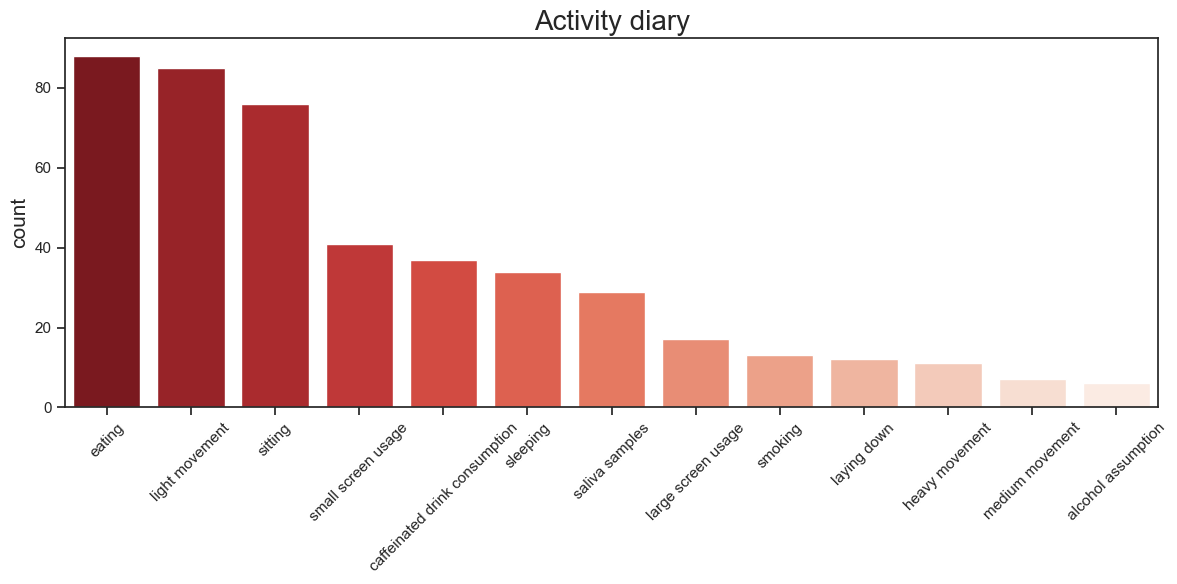

In [10]:
df_activity_count = pd.DataFrame(Counter(activity_summary['Activity']).items(),columns=['Activity','count']) # Create pandas DataFrame with actifity count

# Barplot of activity counter
sns.set(style="ticks")
f,ax = plt.subplots(figsize=(12,6))
df_activity_count = df_activity_count.sort_values('count',ascending=False)
sns.barplot(data=df_activity_count, x='Activity', y='count', palette='Reds_r')
plt.xlabel('')
plt.ylabel('count',fontsize=15)
plt.title('Activity diary',fontsize=20)
plt.xticks(rotation=45)
f.tight_layout()
plt.show()

In [12]:
all_earliest = datetime.strptime("23:59", "%H:%M") + timedelta(days=2)
all_latest = datetime.strptime("00:00", "%H:%M") + timedelta(days=0)
for user, user_df in activity_summary.groupby(by='user'):
    day_start = datetime.strptime("23:59", "%H:%M") + timedelta(days=2)
    day_end = datetime.strptime("00:00", "%H:%M") + timedelta(days=0)
    
    for _, row in user_df.iterrows():
        if not isinstance(row['Start'], str) or not isinstance(row['End'], str) : continue
        _start = datetime.strptime(row['Start'], "%H:%M") + timedelta(days=int(row['Day']))
        _end = datetime.strptime(row['End'], "%H:%M") + timedelta(days=int(row['Day']))
        if _start < day_start:
            day_start = _start
        if _end > day_end:
            day_end = _end

    print(f"User: {user}, Start time: {day_start.strftime('%H:%M')} , End time: {day_end.strftime('%H:%M')}")
    if day_start < all_earliest:
        all_earliest = day_start
    if day_end > all_latest:
        all_latest = day_end

print("==================")
print(f"Overall the most earliest start time is {all_earliest.strftime('%H:%M')}, latest end time is {all_latest.strftime('%H:%M')}")


User: user_1, Start time: 10:00 , End time: 09:35
User: user_10, Start time: 09:50 , End time: 06:50
User: user_11, Start time: 10:20 , End time: 09:23
User: user_12, Start time: 10:00 , End time: 08:35
User: user_13, Start time: 10:00 , End time: 23:30
User: user_14, Start time: 10:16 , End time: 08:50
User: user_15, Start time: 07:30 , End time: 07:45
User: user_16, Start time: 10:05 , End time: 08:30
User: user_17, Start time: 10:15 , End time: 08:55
User: user_18, Start time: 10:10 , End time: 09:00
User: user_19, Start time: 10:00 , End time: 09:10
User: user_2, Start time: 10:00 , End time: 09:15
User: user_20, Start time: 10:00 , End time: 08:25
User: user_21, Start time: 10:20 , End time: 09:00
User: user_22, Start time: 08:50 , End time: 07:04
User: user_3, Start time: 09:50 , End time: 09:35
User: user_4, Start time: 09:45 , End time: 08:55
User: user_5, Start time: 09:50 , End time: 08:10
User: user_6, Start time: 10:39 , End time: 10:00
User: user_7, Start time: 10:00 , End